1. Building a Data Pipeline

In [2]:
import tensorflow as tf 
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-08-29 20:17:05.422794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-29 20:17:05.606595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-29 20:17:05.606642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
import cv2
import imghdr
from matplotlib import pyplot as plt

/tmp/ipykernel_640/3427753027.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [5]:
data_dir = 'data'

In [6]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [7]:
# This would be used for image cleanup:
def image_cleanup():
    for image_class in os.listdir(data_dir):
        for image in os.listdir(os.path.join(data_dir, image_class)):
            image_path = os.path.join(data_dir, image_class, image)
            try:
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    print('Image not in ext list {}'.format(image_path))
            except Exception as e:
                print('Issue with image {}'.format(image_path))
#image_cleanup()

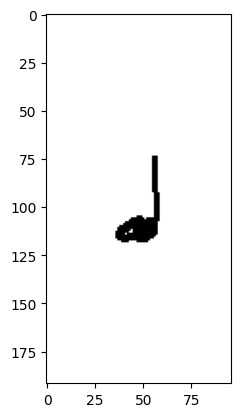

In [8]:
#Test file read and plot
img = cv2.imread(os.path.join('data','Quarter-Note', '9-95_3.png'))
plt.imshow(img)

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
data = tf.keras.utils.image_dataset_from_directory('data')
for batch_images, batch_labels in data.take(1):
    # Print the shape of the batch images
    print("Batch Images Shape:", batch_images.shape)
    # Print the shape of the batch labels
    print("Batch Labels Shape:", batch_labels.shape)

Found 19294 files belonging to 32 classes.


2023-08-29 20:17:28.474709: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-29 20:17:28.474787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-29 20:17:28.474804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-29 20:17:29.689053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-29 20:17:29.689548: I tensorflow/compile

Batch Images Shape: (32, 256, 256, 3)
Batch Labels Shape: (32,)


2. Pre-process Data

In [11]:
input_dir = 'data'
output_dir = 'processed'

desired_size = 256

# Traverse through subfolders and process images
for label_name in os.listdir(input_dir):
    label_dir = os.path.join(input_dir, label_name)
    output_label_dir = os.path.join(output_dir, label_name)
    os.makedirs(output_label_dir, exist_ok=True)
    
    for image_name in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image_name)
        output_image_path = os.path.join(output_label_dir, image_name)
        
        # Load the image in grayscale
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        # Resize while maintaining aspect ratio
        aspect_ratio = image.shape[1] / image.shape[0]
        new_width = int(desired_size * aspect_ratio)
        resized_image = cv2.resize(image, (new_width, desired_size))
        
        # Calculate padding
        padding_needed = desired_size - new_width
        left_padding = max(padding_needed // 2, 0)
        right_padding = max(padding_needed - left_padding, 0)
        
        # Pad the image
        padded_image = cv2.copyMakeBorder(resized_image, 0, 0, left_padding, right_padding, cv2.BORDER_CONSTANT, value=255)
        
        # Create an RGB image
        final_image = np.stack((padded_image,) * 3, axis=-1)
        
        # Save the preprocessed image
        cv2.imwrite(output_image_path, final_image)

In [12]:
pre_processed = tf.keras.utils.image_dataset_from_directory('processed')
scaled_data = pre_processed.map(lambda x, y: (x / 255, y))

Found 19294 files belonging to 32 classes.


In [13]:
train_size = int(len(scaled_data)*.7)
val_size = int(len(scaled_data)*.2)
test_size = int(len(scaled_data)*.1)

In [14]:
train = scaled_data.take(train_size)
val = scaled_data.skip(train_size).take(val_size)
test = scaled_data.skip(train_size+val_size).take(test_size)

3. Deep Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [16]:
model = Sequential()

In [17]:
# Add convolutional layers
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Add a fully connected layer
model.add(Dense(units=128, activation='relu'))

# Add the output layer
num_classes = 32  # Update with the number of classes (symbols) in your OMR task
model.add(Dense(units=num_classes, activation='softmax'))

In [18]:
model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 128)               3

In [20]:
logdir='logs'

In [21]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [22]:

hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2023-08-29 20:21:44.954723: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-08-29 20:21:50.472239: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-29 20:21:51.379187: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-29 20:21:51.410011: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbda8002780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-29 20:21:51.410045: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-08-29 20:21:51.582803: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-29 20:21:52.30810

422/422 [==============================] - 52s 88ms/step - loss: 1.3778 - accuracy: 0.6587 - val_loss: 0.5726 - val_accuracy: 0.8078
Epoch 2/20
422/422 [==============================] - 36s 86ms/step - loss: 0.3017 - accuracy: 0.9005 - val_loss: 0.5059 - val_accuracy: 0.8375
Epoch 3/20
422/422 [==============================] - 37s 86ms/step - loss: 0.1158 - accuracy: 0.9625 - val_loss: 0.5973 - val_accuracy: 0.8464
Epoch 4/20
422/422 [==============================] - 37s 86ms/step - loss: 0.0576 - accuracy: 0.9832 - val_loss: 0.6853 - val_accuracy: 0.8424
Epoch 5/20
422/422 [==============================] - 35s 82ms/step - loss: 0.0445 - accuracy: 0.9854 - val_loss: 0.7955 - val_accuracy: 0.8378
Epoch 6/20
422/422 [==============================] - 36s 85ms/step - loss: 0.0416 - accuracy: 0.9876 - val_loss: 0.7961 - val_accuracy: 0.8505
Epoch 7/20
422/422 [==============================] - 38s 90ms/step - loss: 0.0241 - accuracy: 0.9919 - val_loss: 0.8101 - val_accuracy: 0.8448
Epo

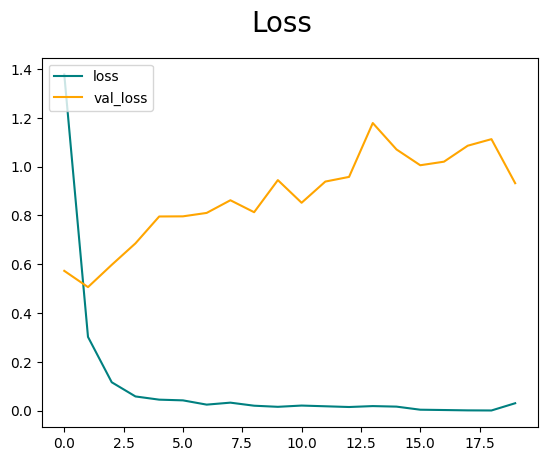

In [23]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

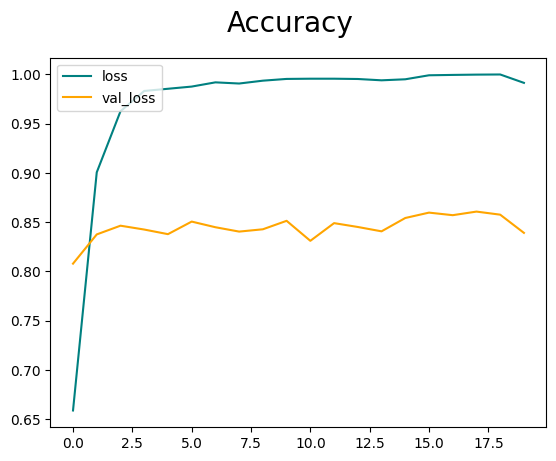

In [24]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='loss')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_loss')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

4. Evaluate Performance

In [30]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

In [31]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [35]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    predicted_classes = np.argmax(yhat, axis=1)
    print(X)
    print(to_categorical(predicted_classes))
    pre.update_state(y, predicted_classes)
    re.update_state(y, predicted_classes)
    acc.update_state(y, predicted_classes)

1/1 [==============================] - 0s 46ms/step
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]


 [[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  

In [36]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.9978836178779602, Recall:0.9992052912712097, Accuracy:0.7666666507720947


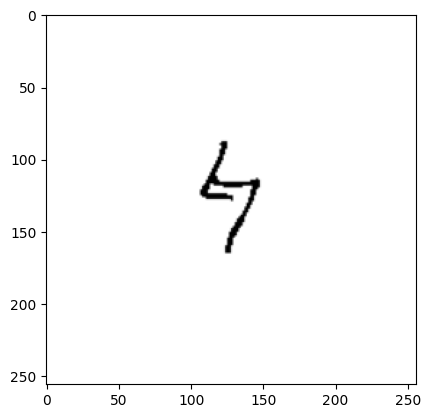

In [75]:
img = cv2.imread('./processed/Natural/3-89_3.png')
plt.imshow(img)
plt.show()

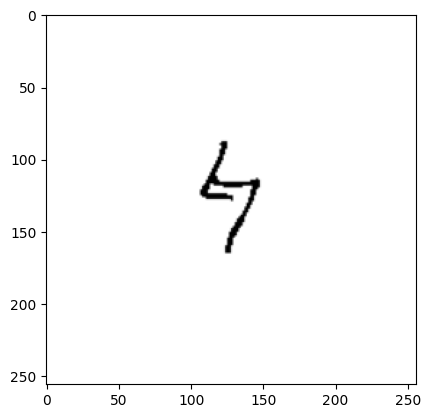

In [76]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [77]:
resize.shape

TensorShape([256, 256, 3])

In [78]:
# Add an extra dimension to fool the model into thinking it's a batch
np.expand_dims(resize, 0)

array([[[[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        ...,

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
       

In [79]:
yhat_test = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 14ms/step


In [80]:
# TODO: Figure out how to actually print which class it predicted? Cuz like rn it's just predicting integers instead of strings
data_dir = 'processed'
class_names = sorted(os.listdir(data_dir))
predictions = yhat_test
print(predictions)
print(predictions.shape)
print(np.argmax(predictions))
print(class_names[np.argmax(predictions)])
all_predictions = predictions[0].tolist()
predicted_with_confidence = [(class_names[i], confidence) for i, confidence in enumerate(all_predictions)]
predicted_with_confidence_sorted = sorted(predicted_with_confidence, key=lambda x: x[1], reverse=True)
for i in range(4):
    note_name, confidence = predicted_with_confidence_sorted[i]
    print(f"Note: {note_name}, Confidence: {confidence:.4f}")

[[1.28784787e-12 7.87886353e-11 2.45319293e-10 1.86795067e-17
  1.49061139e-19 1.43012095e-11 2.67422125e-13 1.98180497e-17
  2.60749430e-13 6.34565456e-11 1.52983341e-15 3.29973702e-16
  1.35980957e-17 4.46369963e-09 2.85582584e-16 2.96785707e-08
  8.99929520e-16 5.83658233e-09 1.43787499e-11 1.25054833e-16
  9.99999404e-01 1.92176478e-14 7.28758109e-10 1.27534416e-09
  2.70434093e-13 5.43038766e-07 2.32583783e-17 1.15561115e-16
  7.74157051e-13 8.42140663e-11 3.37064491e-12 6.31626348e-11]]
(1, 32)
20
Natural
Note: Natural, Confidence: 1.0000
Note: Sixteenth-Rest, Confidence: 0.0000
Note: Eighth-Rest, Confidence: 0.0000
Note: Flat, Confidence: 0.0000


5. Save the Model

In [81]:
from tensorflow.keras.models import load_model

In [83]:
model.save(os.path.join('models','amadeus_model.keras'))

In [ ]:
new_model = load_model(os.path.join('models','amadeus_model.keras'))

In [ ]:
yhat_new = new_model.predict(np.expand_dims(resize/255, 0))

In [ ]:
# TODO: Figure out how to actually print which class it predicted? Cuz like rn it's just predicting integers instead of strings
to_categorical(np.argmax(yhat_new, axis=1))